In [2]:
!pip install -q sociophysicsDataHandler 
from sociophysicsDataHandler import SociophysicsDataHandler
dh = SociophysicsDataHandler()
p = """guest
YDPGL-XREXC-QGMZS-UAKES"""
c = """text_file = open("auth.txt", "w+");text_file.write(p);text_file.close()""" 
exec(c)

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import math as math
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns;
from scipy.signal import fftconvolve
from scipy.linalg import solve
from ipywidgets import IntProgress
from IPython.display import display

try:
    from PIL import Image
except ImportError:
    import Image

In [4]:
def fetch_ehv(date: int, hour = -1, station='ehv', platform='platform2.1'):
    """If hour is given, fetches the data for that hour of that date; else, it creates a dataframe of the list of dates.
    An example format for the date is 20220115. An empty dataframe is returned in case of missing data.
    """
    assert -1 <= hour < 24
      
    file_path = station + '/' + platform + '/' + str(date)
    file_list = dh.list_files(file_path)
    
    if hour == -1:
        return file_list
    else:
        try:
            dh.fetch_prorail_data_from_path(file_path + '/' + file_list.name.iloc[hour])
            df = dh.df.copy()
            return df
        except:
            print(file_path + f', hour {hour} is missing.')
            df = pd.DataFrame(columns = ('date_time_utc', 'tracked_object', 'x_pos','y_pos'))
        return df

targeting path /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20221109
Files listed. Accessible as <this-object>.filelist
trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20221109/EHV_Platform2.1_2022110900_trajectorie.parquet
data fetched. Accessible as <this-object>.df
targeting path /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20221109
Files listed. Accessible as <this-object>.filelist
trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20221109/EHV_Platform2.1_2022110901_trajectorie.parquet
data fetched. Accessible as <this-object>.df
targeting path /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20221109
Files listed. Accessible as <this-object>.filelist
trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20221109/EHV_Platform2.1_2022110902_trajectorie.parquet
data fetched. Accessible as <this-object>.df
targeting path /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20221109
Files listed. Acces

NameError: name 'df' is not defined

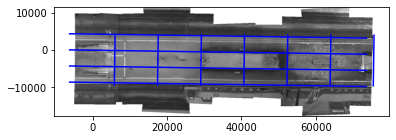

In [5]:
a = [fetch_ehv(20221109, i) for i in range(0, 23)]

dff = pd.concat(a)

a1 = dff.groupby('y_pos').max()[['x_pos']]
a2 = dff.groupby('y_pos').min()[['x_pos']]

c = a1.groupby(pd.cut(a1.index, bins=40)).max().rename(columns={'x_pos':'x_max'}).join(a2.groupby(pd.cut(a2.index, bins=40)).min().rename(columns={'x_pos':'x_min'}))

c.index = [d.left for d in c.index.values]

M1 = np.matrix([[1, 0, y] for y in c.index])
M2 = np.matrix([[0, 1, y] for y in c.index])

M = np.concatenate([M1, M2])

b_min, b_max, a = solve(M.T*M, M.T * np.concatenate([c['x_min'].to_numpy().reshape((len(c), 1)),
                                  c['x_max'].to_numpy().reshape((len(c), 1))])).flatten()

b1 = b_min + (b_max - b_min)/3
b2 = b_min + (b_max - b_min)*2/3

bs = [b_min, b1, b2, b_max]

y_max = dff['y_pos'].max()

ax = -1/a
d_min = b_max + (a+1/a)*6000
d_max = b_max + (a+1/a)*y_max

d1 = d_min + (d_max - d_min)*1/6
d2 = d_min + (d_max - d_min)*2/6
d3 = d_min + (d_max - d_min)*3/6
d4 = d_min + (d_max - d_min)*4/6
d5 = d_min + (d_max - d_min)*5/6

ds = [d_min, d1, d2, d3, d4, d5, d_max]

fig, axes = plt.subplots(1)

dh.fetch_background_image_from_path('ehv/background_images/EHV.Perron2.1_multisensor.png')
image = dh.bg

axes.imshow(image, extent=[-5134, 75135, -17731, 11645])

axes.plot(c.index, c.index*a + b_max, 'b')
axes.plot(c.index, c.index*a + b_min, 'b')

axes.plot(c.index, c.index*a + b1, 'b')
axes.plot(c.index, c.index*a + b2, 'b')

inter = 11615

axes.plot(np.linspace(5800, 6000), np.linspace(5800, 6000)*ax + d_min, 'b')
axes.plot(np.linspace(inter+5800, inter+6000), np.linspace(inter+5800, inter+6000)*ax + d1, 'b')
axes.plot(np.linspace(2*inter+5800, 2*inter+6000), np.linspace(2*inter+5800, 2*inter+6000)*ax + d2, 'b')
axes.plot(np.linspace(3*inter+5800, 3*inter+6000), np.linspace(3*inter+5800, 3*inter+6000)*ax + d3, 'b')
axes.plot(np.linspace(4*inter+5800, 4*inter+6000), np.linspace(4*inter+5800, 4*inter+6000)*ax + d4, 'b')
axes.plot(np.linspace(5*inter+5800, 5*inter+6000), np.linspace(5*inter+5800, 5*inter+6000)*ax + d5, 'b')
axes.plot(np.linspace(6*inter+5800, 6*inter+6000), np.linspace(6*inter+5800, 6*inter+6000)*ax + d_max, 'b')

In [34]:
df = pd.read_csv('CompressedData ehv all multibin.csv')

df_geometry = pd.DataFrame(index=df.columns[4:], columns=['left_up', 'right_up', 'right_down', 'left_down'])



df_geometry['left_down'] = [((d-b)/(a+1/a), a*(d-b)/(a+1/a) + b) for d in ds[:-1] for b in bs[:-1]]

df_geometry['right_down'] = [((d-b)/(a+1/a), a*(d-b)/(a+1/a) + b) for d in ds[1:] for b in bs[:-1]]

df_geometry['right_up'] = [((d-b)/(a+1/a), a*(d-b)/(a+1/a) + b) for d in ds[1:] for b in bs[1:]]

df_geometry['left_up'] = [((d-b)/(a+1/a), a*(d-b)/(a+1/a) + b) for d in ds[:-1] for b in bs[1:]]

df_geometry.to_csv('Geometry ehv all multibin.csv')

df_geometry

,left_up,right_up,right_down,left_down
"0, 0","(5872.504371452557, -4503.331900559877)","(17485.50437145256, -4674.067866046973)","(17421.756557178836, -9010.022303348469)","(5808.7565571788355, -8839.286337861373)"
"1, 0","(5936.252185726278, -167.37746325838026)","(17549.252185726284, -338.1134287454759)","(17485.50437145256, -4674.067866046973)","(5872.504371452557, -4503.331900559877)"
"2, 0","(6000.0, 4168.576974043117)","(17613.000000000004, 3997.8410085560217)","(17549.252185726284, -338.1134287454759)","(5936.252185726278, -167.37746325838026)"
"0, 1","(17485.50437145256, -4674.067866046973)","(29098.50437145256, -4844.803831534068)","(29034.756557178836, -9180.758268835565)","(17421.756557178836, -9010.022303348469)"
"1, 1","(17549.252185726284, -338.1134287454759)","(29162.252185726284, -508.8493942325714)","(29098.50437145256, -4844.803831534068)","(17485.50437145256, -4674.067866046973)"
"2, 1","(17613.000000000004, 3997.8410085560217)","(29226.000000000004, 3827.105043068926)","(29162.252185726284, -508.8493942325714)","(17549.252185726284, -338.1134287454759)"
"0, 2","(29098.50437145256, -4844.803831534068)","(40711.50437145257, -5015.539797021163)","(40647.756557178844, -9351.494234322661)","(29034.756557178836, -9180.758268835565)"
"1, 2","(29162.252185726284, -508.8493942325714)","(40775.252185726284, -679.5853597196669)","(40711.50437145257, -5015.539797021163)","(29098.50437145256, -4844.803831534068)"
"2, 2","(29226.000000000004, 3827.105043068926)","(40839.000000000015, 3656.3690775818304)","(40775.252185726284, -679.5853597196669)","(29162.252185726284, -508.8493942325714)"
"0, 3","(40711.50437145257, -5015.539797021163)","(52324.50437145257, -5186.2757625082595)","(52260.756557178844, -9522.230199809756)","(40647.756557178844, -9351.494234322661)"


In [11]:
# defining overarching dataframe
df_collect = pd.DataFrame(columns=['N','p_left','p_right'])

# Define the date list
file_list = dh.list_files('ehv/platform2.1')['name'].to_numpy('int32')
dates = file_list[file_list < 20211101]

f = IntProgress(min=24*(len(file_list)-len(dates)), max=len(file_list)*24) # instantiate the bar
display(f)

for j in dates:
    print(j)
    for i in range(24):
        # fetching the dataframe
        try:
            df = fetch_ehv(j, i);
        except:
            print(f'Could not load frame {str(j)}, {i}')
            continue

        if len(df) > 0:

            # binning the data
            for di in range(len(ds)-1):
                for bi in range(len(bs)-1):
                    df[f'{bi}, {di}'] = (df['x_pos'] > a*df['y_pos']+bs[bi]) & (df['x_pos'] < a*df['y_pos']+bs[bi+1]) & (df['x_pos'] < ax*df['y_pos']+ds[di]) & (df['x_pos'] > ax*df['y_pos']+ds[di+1])
            
            df['left_bin'] = df['y_pos'] < 40000
            df['right_bin'] = df['y_pos'] >= 40000

            df_bins = df.drop(['tracked_object', 'x_pos', 'y_pos'], axis=1).groupby('date_time_utc').sum()

            df_bins['N'] = df_bins['left_bin'] + df_bins['right_bin']
            df_bins['p_left'] = df_bins['left_bin']/df_bins['N']
            df_bins['p_right'] = df_bins['right_bin']/df_bins['N']

            df_bins.drop(['left_bin', 'right_bin'], axis=1, inplace=True)

            # filtering the data on trains
            sigma = 500

            l = len(df_bins['N'])

            gauss_k = np.array([np.exp(-(i-l/2)**2/(2*sigma**2)) for i in range(l)]) * (1/(sigma * np.sqrt(2*np.pi)))

            gauss_der = np.convolve(gauss_k, np.array([1, 0, -1]))

            der = fftconvolve(df_bins['N'].to_numpy(), gauss_der)[int(np.floor(l/2)):int(l+np.floor(l/2))]

            cond = np.logical_and(der > 0, der < 0.03)

            df_filtered = df_bins[cond]

            # sampling the data
            df_sample = df_filtered.iloc[list(range(0, len(df_filtered), 1000)), :]

            # add to existing dataframe
            df_collect = df_collect.append(df_sample)
            f.value += 1

df_collect.to_csv('CompressedData ehv test.csv')
            
df_collect

targeting path /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1
Files listed. Accessible as <this-object>.filelist


IntProgress(value=9048, max=14208, min=9048)

20210330
targeting path /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20210330
Files listed. Accessible as <this-object>.filelist
trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20210330/EHV_Platform2.1_2021033008_trajectorie.parquet
data fetched. Accessible as <this-object>.df
targeting path /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20210330
Files listed. Accessible as <this-object>.filelist
trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20210330/EHV_Platform2.1_2021033009_trajectorie.parquet
data fetched. Accessible as <this-object>.df
targeting path /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20210330
Files listed. Accessible as <this-object>.filelist
trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20210330/EHV_Platform2.1_2021033010_trajectorie.parquet
data fetched. Accessible as <this-object>.df
targeting path /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20210330
Files list

KeyboardInterrupt: 

In [3]:
#df_collect.to_csv('CompressedData ehv all intermediate.csv')

pd.read_csv('CompressedData ehv all multibin.csv')

,Unnamed: 0,N,p_left,p_right,"0, 0","1, 0","2, 0","0, 1","1, 1","2, 1",...,"2, 2","0, 3","1, 3","2, 3","0, 4","1, 4","2, 4","0, 5","1, 5","2, 5"
0,1.617093e+12,34,0.735294,0.264706,2.0,5.0,1.0,1.0,3.0,2.0,...,4.0,2.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0
1,1.617093e+12,16,0.937500,0.062500,4.0,0.0,3.0,0.0,2.0,2.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.617093e+12,27,0.777778,0.222222,1.0,2.0,2.0,0.0,3.0,2.0,...,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0
3,1.617093e+12,29,0.655172,0.344828,0.0,2.0,3.0,0.0,4.0,2.0,...,3.0,0.0,0.0,5.0,0.0,3.0,1.0,0.0,0.0,1.0
4,1.617093e+12,38,0.631579,0.368421,0.0,5.0,2.0,1.0,3.0,4.0,...,4.0,0.0,0.0,5.0,0.0,6.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175634,1.668380e+12,17,0.705882,0.294118,0.0,2.0,2.0,0.0,8.0,0.0,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0
175635,1.668380e+12,18,0.888889,0.111111,0.0,2.0,3.0,1.0,8.0,1.0,...,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
175636,1.668380e+12,24,0.875000,0.125000,0.0,3.0,0.0,1.0,10.0,3.0,...,4.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
175637,1.668380e+12,39,0.897436,0.102564,0.0,6.0,2.0,2.0,11.0,9.0,...,3.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0


In [12]:
file_list[file_list > 20220217]

array([20220218, 20220219, 20220220, 20220221, 20220222, 20220223,
       20220224, 20220225, 20220226, 20220227, 20220228, 20220301,
       20220302, 20220303, 20220304, 20220305, 20220306, 20220307,
       20220308, 20220309, 20220310, 20220311, 20220312, 20220313,
       20220314, 20220315, 20220316, 20220317, 20220318, 20220319,
       20220320, 20220321, 20220322, 20220323, 20220324, 20220325,
       20220326, 20220327, 20220328, 20220329, 20220330, 20220331,
       20220401, 20220402, 20220403, 20220404, 20220405, 20220406,
       20220407, 20220408, 20220409, 20220410, 20220411, 20220412,
       20220413, 20220414, 20220415, 20220416, 20220417, 20220418,
       20220419, 20220420, 20220421, 20220422, 20220423, 20220424,
       20220425, 20220426, 20220427, 20220428, 20220429, 20220430,
       20220501, 20220502, 20220503, 20220504, 20220505, 20220506,
       20220507, 20220508, 20220509, 20220510, 20220511, 20220512,
       20220513, 20220514, 20220515, 20220516, 20220517, 20220

In [308]:
df_collect

,N,p_left,p_right,"0, 0","1, 0","2, 0","0, 1","1, 1","2, 1","0, 2",...,"2, 2","0, 3","1, 3","2, 3","0, 4","1, 4","2, 4","0, 5","1, 5","2, 5"
1.617093e+12,34,0.735294,0.264706,2.0,5.0,1.0,1.0,3.0,2.0,3.0,...,4.0,2.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0
1.617093e+12,16,0.937500,0.062500,4.0,0.0,3.0,0.0,2.0,2.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1.617093e+12,27,0.777778,0.222222,1.0,2.0,2.0,0.0,3.0,2.0,5.0,...,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0
1.617093e+12,29,0.655172,0.344828,0.0,2.0,3.0,0.0,4.0,2.0,0.0,...,3.0,0.0,0.0,5.0,0.0,3.0,1.0,0.0,0.0,1.0
1.617093e+12,38,0.631579,0.368421,0.0,5.0,2.0,1.0,3.0,4.0,1.0,...,4.0,0.0,0.0,5.0,0.0,6.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.623163e+12,48,0.479167,0.520833,2.0,1.0,1.0,4.0,3.0,2.0,6.0,...,3.0,10.0,0.0,0.0,3.0,3.0,1.0,4.0,1.0,2.0
1.623163e+12,68,0.529412,0.470588,4.0,5.0,1.0,3.0,5.0,4.0,5.0,...,5.0,10.0,0.0,1.0,6.0,8.0,0.0,4.0,0.0,3.0
1.623163e+12,70,0.557143,0.442857,1.0,3.0,0.0,8.0,4.0,4.0,8.0,...,4.0,6.0,0.0,4.0,7.0,7.0,2.0,2.0,2.0,1.0
1.623164e+12,17,0.470588,0.529412,0.0,0.0,1.0,1.0,2.0,2.0,0.0,...,2.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0


In [309]:
j

20210608